In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN, CNN_pool
import matplotlib.pyplot as plt
import pyreadr

In [7]:
# Dataloader
exp = "exp_3_1"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, batch_size = 1500)

In [8]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
for sample in dataloader:
    img, param, model = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()
model = model.detach().numpy()

In [10]:
len(dataloader)

1

In [11]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:,0] = params[:,0]*(3-0.1)+0.1
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [12]:
def get_metrics(pred_tf, param_tf):
    rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
    mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
    bias = np.mean(pred_tf-param_tf, axis = 0)
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Bias: {np.round(bias,2)}")

In [13]:
pred_tf_full = retransform(pred)
param_tf_full = retransform(param)

In [14]:
# Brown metrics
get_metrics(pred_tf_full[model==0],param_tf_full[model==0])

RMSE: [0.61 0.17]
MAE: [0.46 0.13]
Bias: [0.13 0.02]


In [15]:
get_metrics(pred_tf_full[model==1],param_tf_full[model==1])

RMSE: [0.72 0.28]
MAE: [0.55 0.19]
Bias: [ 0.1  -0.04]


In [16]:
# Plot results
n_comb = 25
n_each = 30

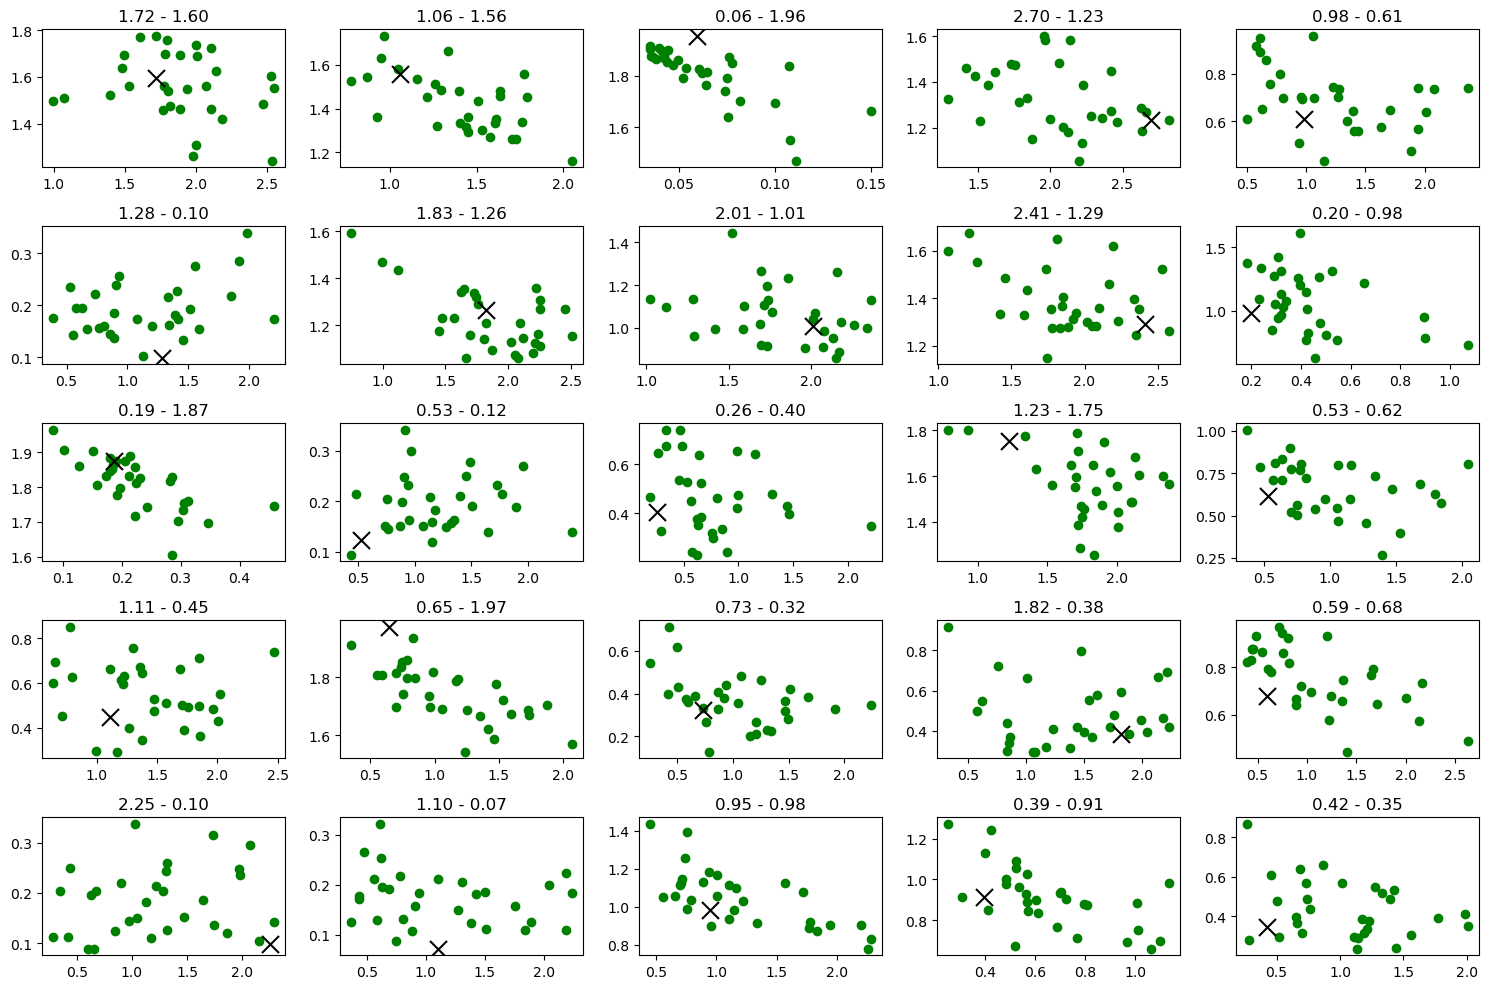

In [28]:
#Brown
pred_tf = pred_tf_full[model==0]
param_tf = param_tf_full[model==0]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

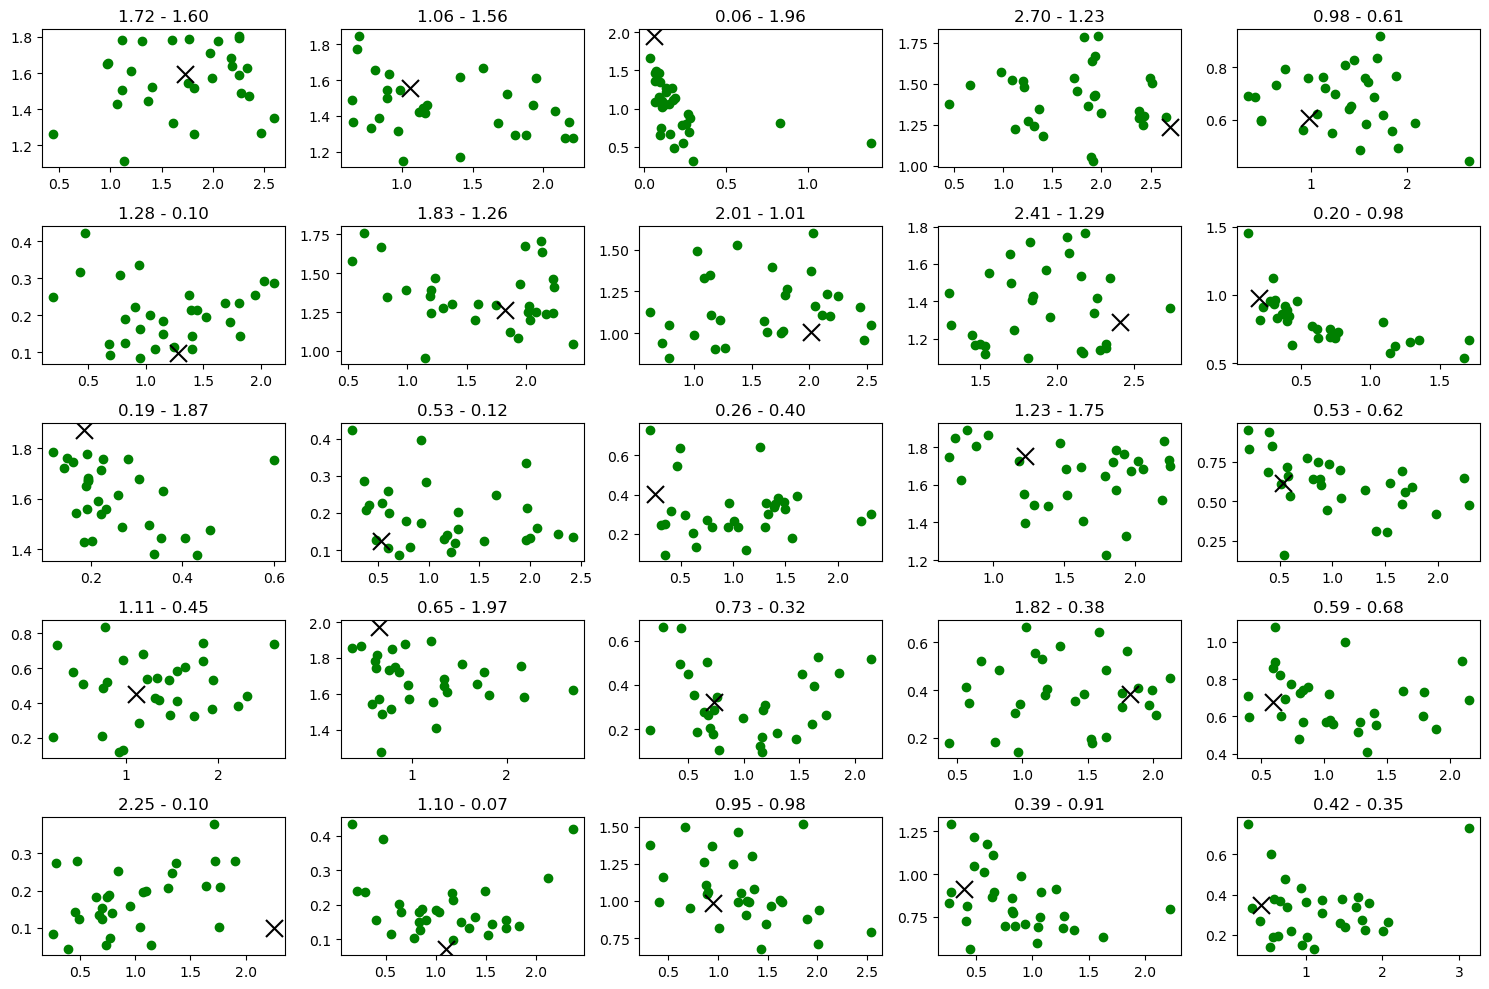

In [29]:
#Schlather
pred_tf = pred_tf_full[model==1]
param_tf = param_tf_full[model==1]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()